# LowEmission Oil and Gas Open (LEOGO) reference platform

Representing a hypothetical, but realistic Norwegian offshore oil and gas platform

* wellstream: 50 Sm3/s, of which:
    * gas: 49.75 Sm3/s = 4.3 mill Sm3/day = 4300 Sm3oe/day
    * oil:  0.1 Sm3/s = 8640 Sm3/day  
    * water: 0.15 Sm3/s = 12960 Sm3/day 
* GOR = 4.3 mill/8640 = 497 (gas oil ratio)
* WC = 12960/(12960+8640) = 0.6 (water cut)

In this notebook, four cases are considered
* Base case with power supply from 3 gas turbine generators
* Case A with added wind power
* Case B with added wind power and a battery
* Case C with added wind power and hydrogen storage

In [2]:
%load_ext autoreload
%autoreload 2
import oogeso
import oogeso.plots as plots
import oogeso.result_analysis
import matplotlib.pyplot as plt
import IPython.display
import pandas as pd
import logging
import pprint
import ipywidgets
import pickle
import plotly.express as px
import pyomo.environ as pyo
import os
from pathlib import Path
EXAMPLE_DATA_ROOT_PATH = Path(os.path.abspath("")) # present path
TEST_DATA_ROOT_PATH = EXAMPLE_DATA_ROOT_PATH.parent / "tests/test_data"

## Read input data

Specify simulation case and make necessary modifications to the input data

In [3]:
#case='Base' # base case without wind
case='A' # case with 24 MW wind capacity
#case='B' # case with 24 MW wind capacity AND 4 MW, 4 MWh battery
#case="C" # case with hydrogen
timerange=[0,40] # testing
outpath = "result/"
plots.plotter="plotly"

data = oogeso.io.read_data_from_yaml(TEST_DATA_ROOT_PATH / "leogo_reference_platform.yaml")
timeseries = oogeso.io.read_profiles_from_csv(
    filename_nowcasts= TEST_DATA_ROOT_PATH / "leogo_profiles_nowcasts.csv",
    filename_forecasts= TEST_DATA_ROOT_PATH / "leogo_profiles_forecasts.csv")
profiles = oogeso.utils.create_time_series_data(
    df_forecast= timeseries["forecast"],
    df_nowcast=timeseries["nowcast"],
    time_start=None,time_end=None,
    timestep_minutes=5,
    resample_method="linear")
data.profiles = profiles

#data['paramParameters']['planning_horizon']=12

incl_battery=0
incl_hydrogen=0
if case=='Base':
    wind_P_max=0 # no wind
elif case=='A':
    wind_P_max=8*3 # 3x8 MW, as agreed with ABB
elif case=='B':
    wind_P_max=8*3 # 3x8 MW, as agreed with ABB
    incl_battery=1
elif case=="C":
    wind_P_max=8*12 # Large wind farm Pmax=2x demand
    incl_hydrogen=1
    data.parameters.co2_tax=1000
    prof_h2target=oogeso.dto.oogeso_input_data_objects.TimeSeriesData(id="h2target",data=[0.5]*len(data.profiles[0].data))
    data.profiles.append(prof_h2target)

gts = ['Gen1','Gen2','Gen3']
wells = ['wellL1', 'wellL2']
hydrogendevices = ['electrolyser','fuelcell','h2storage']
for dev in data.devices:
    if dev.id == "wind":
        dev.flow_max = wind_P_max
    if dev.id == "battery":
        dev.include = incl_battery
    if dev.id in wells:
        # fixed production - not allowed to reduce:
        dev.flow_min = dev.flow_max
    if dev.id in hydrogendevices:
        dev.include = incl_hydrogen

simulator = oogeso.Simulator(data)


### Inspect input data

In [4]:
@ipywidgets.interact(datagroup=['','devices','nodes','edges','carriers','parameters'])
def showdata(datagroup):
    pprint.pprint(data.dict()[datagroup],indent=1) if datagroup!='' else print('')

yy=['']+list(simulator.optimiser.component_objects(oogeso.optimiser.pyo.Constraint, active=True))
@ipywidgets.interact(constraint=yy)
def showdata(constraint):
    pprint.pprint(constraint.pprint(),width=1) if constraint!='' else print('')

interactive(children=(Dropdown(description='datagroup', options=('', 'devices', 'nodes', 'edges', 'carriers', …

interactive(children=(Dropdown(description='constraint', options=('', <pyomo.core.base.constraint.IndexedConst…

In [5]:
# View profiles (entire available time windows)
fig=plots.plot_profiles(profiles,filename=None)
fig.update_layout(template="plotly_white",autosize=False,width=600,height=200,margin=dict(l=0,r=0,t=30,b=1),
                  title="Time series profiles")
fig.show()


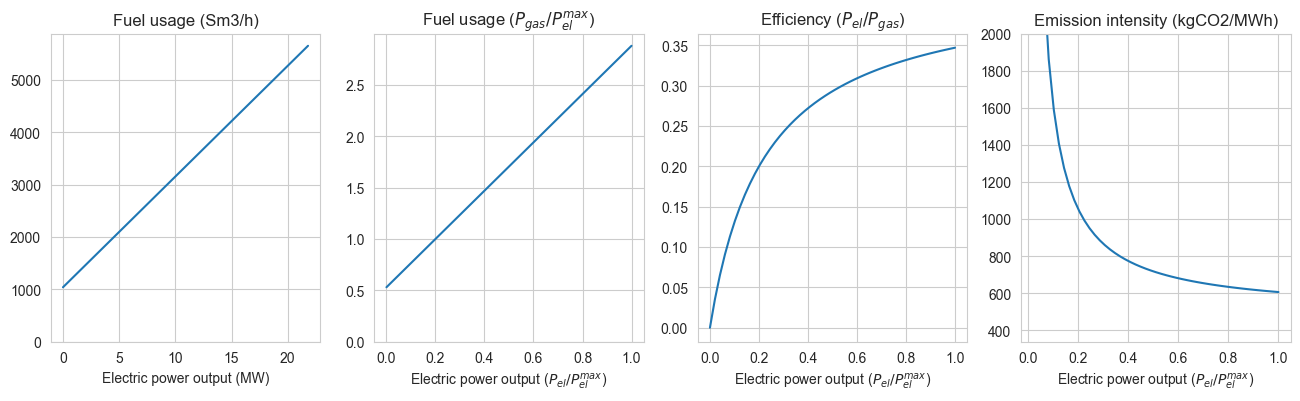

In [6]:
dev=simulator.optimiser.all_devices['Gen1'].dev_data
plots.plot_gas_turbine_efficiency(filename=None,fuel_A=dev.fuel_A,fuel_B=dev.fuel_B,P_max=dev.flow_max)

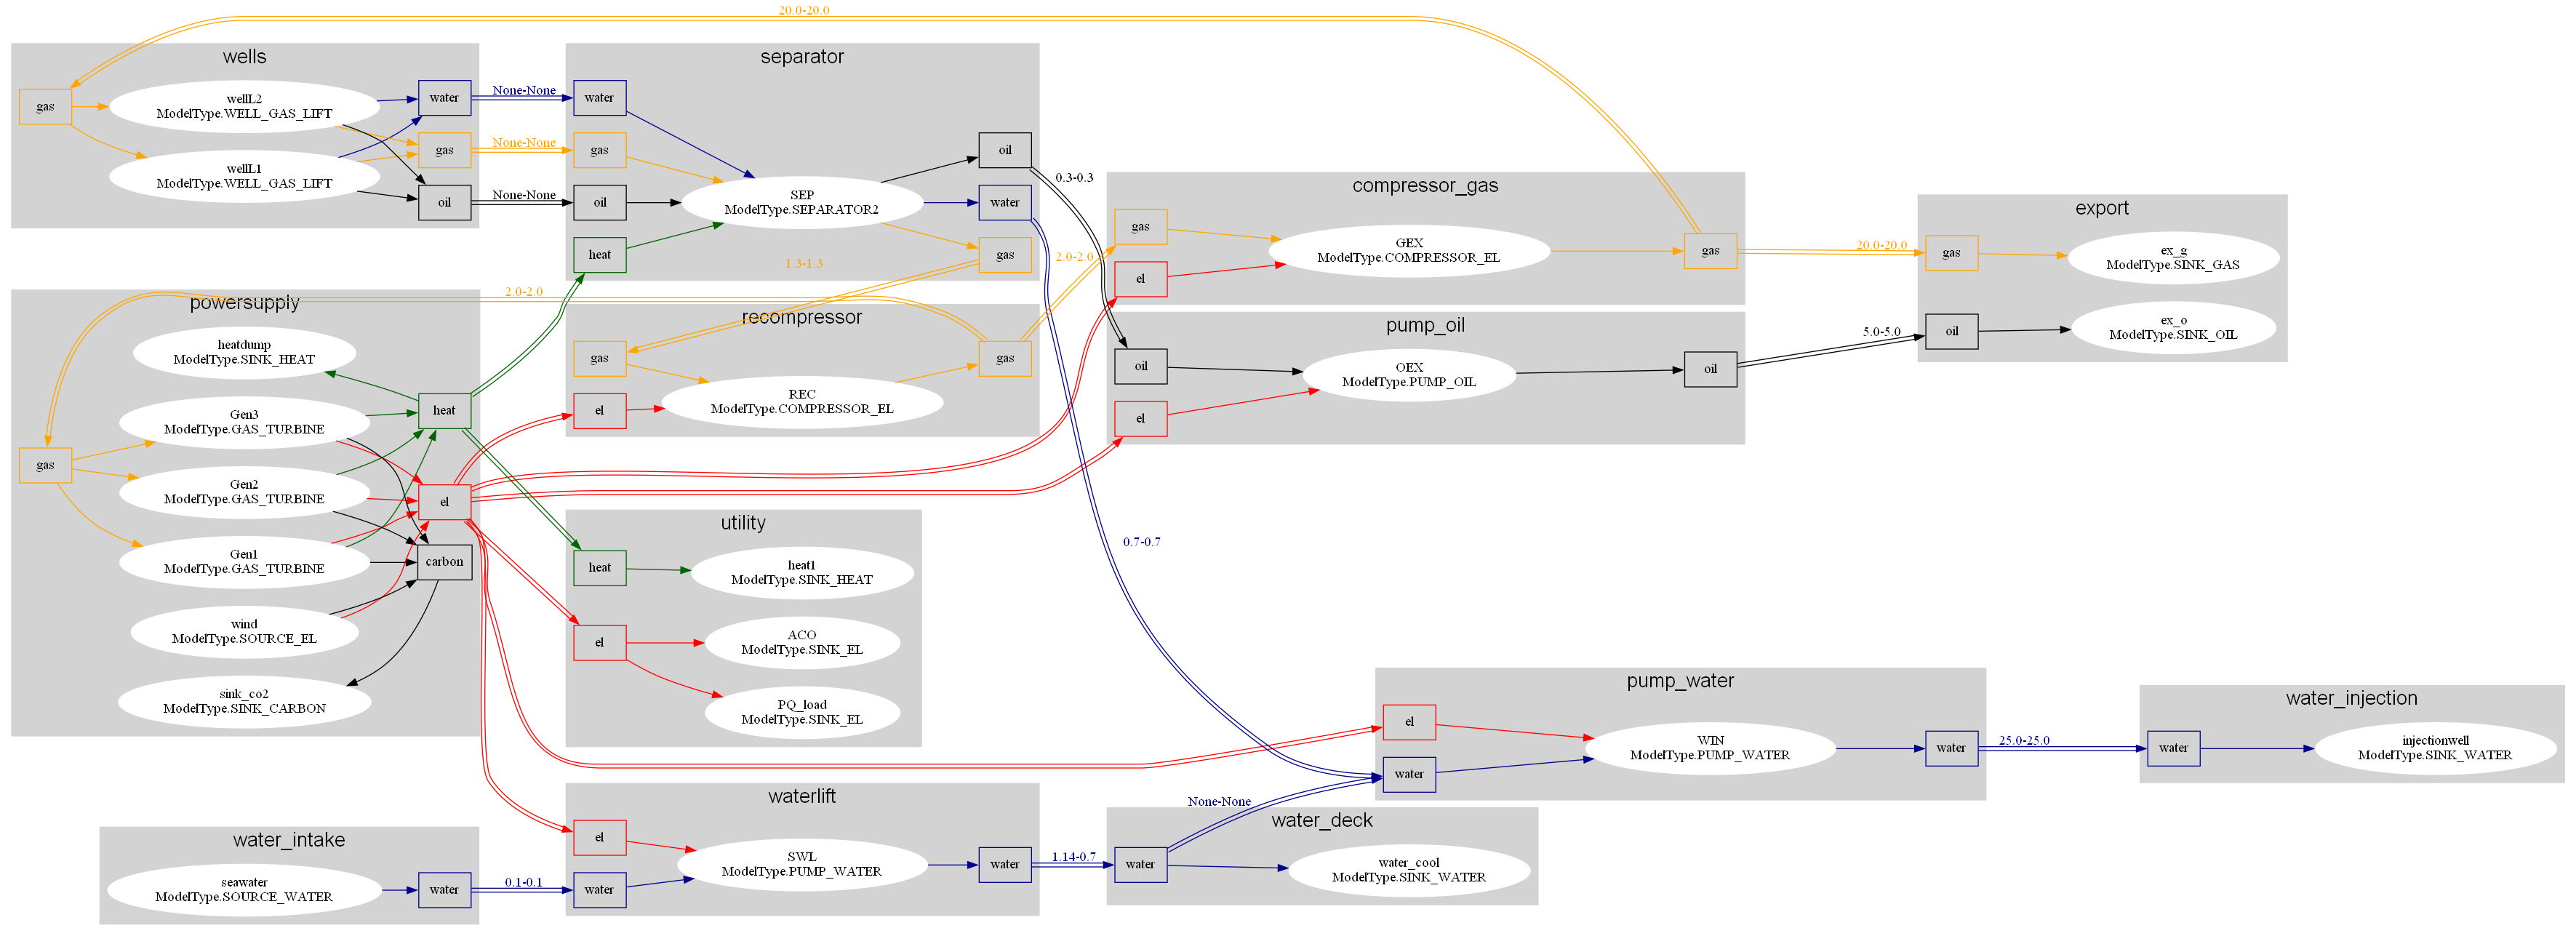

In [7]:
# View energy system
dotG=plots.plot_network(simulator,timestep=None,filename=None,hide_edgelabel=True,only_carrier=None,fontsize=20,fontname = "helvetica",)
IPython.display.Image(dotG.create_png(prog="dot")) #scales automatically to page width
#Save to file:
#dotG.write_pdf(path=outpath+"diagram0_{}.pdf".format(case))

## Solve

If the problem is infeasible, try 
* relaxing pressure deviation limits (generic value and per-node value)
* add a high cost emergency generator (that could represent load shedding) to ensure energy balance can be satisfied
* make sure excess heat/water/gas has a place to go


In [8]:
sim_result = simulator.run_simulation(solver="cbc",time_range=timerange,write_yaml=False,time_limit=20)

100%|██████████| 7/7 [00:05<00:00,  1.32it/s]


In [9]:
print("Mean CO2 emission rate      = {:.1f} kgCO2/s".format(sim_result.co2_rate.mean()))
print("Mean CO2 emission intensity = {:.1f} kgCO2/Sm3oe".format(sim_result.co2_intensity.mean()))
print("Mean export revenue         =",*["{}:{:.1f} ".format(x,v) for x,v in 
                                        sim_result.export_revenue.unstack("carrier").mean().items() if v!=0],"$/s")

Mean CO2 emission rate      = 8.0 kgCO2/s
Mean CO2 emission intensity = 55.9 kgCO2/Sm3oe
Mean export revenue         = carbon:-6.4  gas:190.6  oil:409.8  $/s


In [10]:
# If we want to export optimisation problem to file, e.g. for debugging:
# simulator.optimiser.write("leogo_optimisation_problem.mps",io_options = {"symbolic_solver_labels":True})

In [11]:
save_results = False
import json
if save_results:
    import oogeso.dto.serialisation
    with open("leogo_resultobject.json", "w") as outfile:
        json.dump(sim_result, fp=outfile, cls=oogeso.dto.serialisation.DataclassJSONEncoder, indent=2)


## Save/Load simulation results
By saving to pickle file, it easy to later open and analyse the results without having to re-run the simulation

In [12]:
save_to_file = False
if save_to_file:
    pickle_save='{}case{}.pkl'.format(outpath,case)
    # Save (pickle) - for later opening and analysis
    dumpdata={"data":data,"result":sim_result}
    with open(pickle_save, mode='wb') as file:
       pickle.dump(dumpdata, file)
    print("Results were saved to {}".format(pickle_save))

In [13]:
read_from_file = False
if read_from_file:
    pickle_save='{}case{}.pkl'.format(outpath,case)
    # Open previously saved object (including simulation results)
    with open(pickle_save, mode='rb') as file:
       sim_data = cloudpickle.load(file)
    data=sim_data["data"]
    sim_result=sim_data["result"]

## Analyse results

In [14]:
kpi = oogeso.result_analysis.compute_kpis(sim_result, sim_data=data, wind_turbines=['wind'])
kpi = pd.DataFrame.from_dict(kpi,orient="index",columns=[case])
kpi 

,A
hours_simulated,3.500000e+00
kgCO2_per_year,2.524731e+08
kgCO2_per_Sm3oe,5.587633e+01
gt_fuel_sm3_per_year,1.078945e+08
elconsumption_mwh_per_year,4.110770e+05
elconsumption_avg_mw,4.692660e+01
gt_starts_per_year,0.000000e+00
gt_stops_per_year,0.000000e+00
gt_hoursrunning_per_year,2.628000e+04
wind_output_mwh_per_year,3.048337e+04


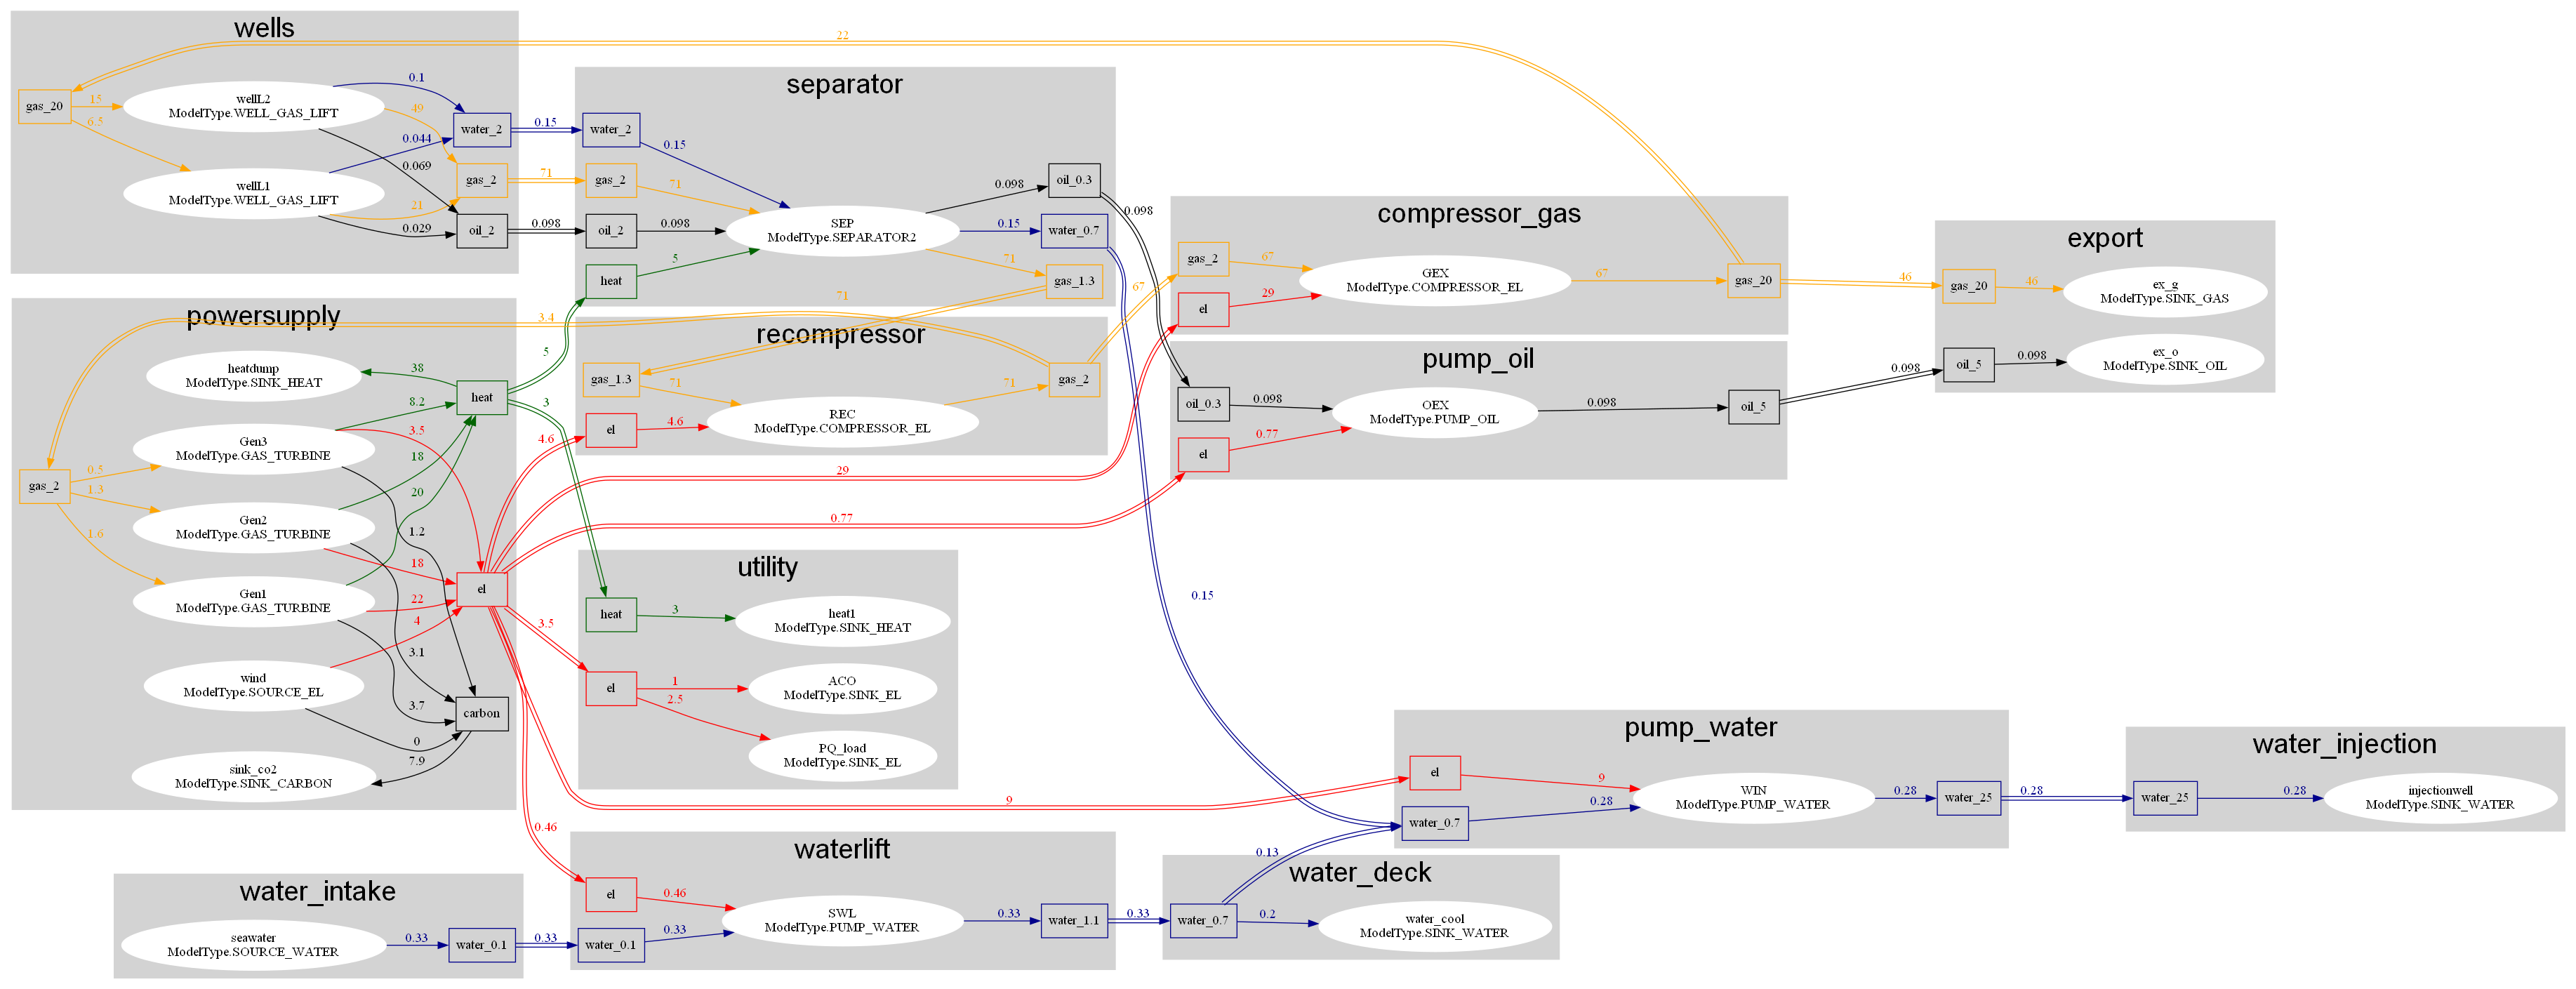

In [15]:
tstep=0
gCombined = plots.plot_network(simulator=simulator,timestep=tstep,numberformat="{:.3g}",
                              filename=None,only_carrier=None,fontsize=30,fontname = "helvetica",
                              hide_losses=True)
IPython.display.Image(gCombined.create_png())
#gCombined.write_png(path=outpath+"diagram_{}.pdf".format(case),f="pdf")
#gCombined.write_pdf(path=outpath+"diagram_{}.pdf".format(case))

In [16]:
print("CHECKING edge pressure drop on selected edges:")
optimiser = simulator.optimiser
print('w1: {:.5g} MPa'.format(optimiser.all_networks["water"].compute_edge_pressuredrop(optimiser.all_edges['w1'],Q=1.15,p1=0.7,linear=True)))
print('w3: {:.5g} MPa'.format(optimiser.all_networks["water"].compute_edge_pressuredrop(optimiser.all_edges['w3'],Q=1.3/15,p1=7,linear=False)))
print('o2: {:.5g} MPa'.format(optimiser.all_networks["oil"].compute_edge_pressuredrop(optimiser.all_edges['o2'],Q=0.1,p1=5,linear=True)))
print('g2: {:.5g} MPa'.format(optimiser.all_networks["gas"].compute_edge_pressuredrop(optimiser.all_edges['g2'],Q=48,p1=10,linear=True)))

CHECKING edge pressure drop on selected edges:
w1: 0.10239 MPa
w3: 6.6222 MPa
o2: 5 MPa
g2: 10 MPa


In [17]:
fig2=plots.plot_sum_power_mix(sim_result,simulator.optimiser,carrier="el",filename=None,devs_shareload=[])
fig2.update_layout(autosize=False,width=800,height=500,margin=dict(l=0,r=0,t=30,b=0),title="Power supply and demand")
fig2.show()

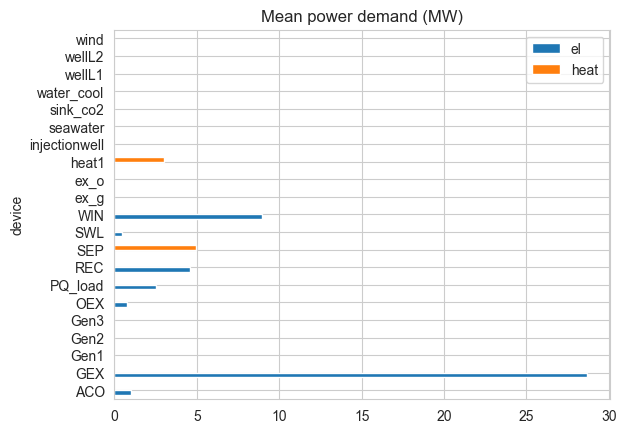

In [18]:
mean_el_demand = sim_result.device_flow.unstack('carrier')['el'].unstack('terminal')['in'].dropna().unstack().T.mean()
mean_heat_demand = sim_result.device_flow.unstack('carrier')['heat'].unstack('terminal')['in'].dropna().unstack().T.mean()
energydemand = pd.concat({'el':mean_el_demand,'heat':mean_heat_demand},axis=1)
energydemand.drop('heatdump',inplace=True)
energydemand.plot.barh(title="Mean power demand (MW)");

In [19]:
energydemand.sum()

el      46.926601
heat     7.946529
dtype: float64

In [20]:
mean_flows=sim_result.device_flow.unstack(["carrier","device","terminal"]).mean().unstack(["carrier","terminal"])
print("Mean flows:\n",mean_flows.sum())
print("Mean flow per device:")
mean_flows

Mean flows:
 carrier   terminal
carbon    in            8.005869
          out           8.005869
el        in           46.926601
          out          46.926601
gas       in          278.259451
          out         278.259451
heat      in           46.702847
          out          46.702847
hydrogen  in            0.000000
          out           0.000000
oil       in            0.293417
          out           0.293417
water     in            1.230400
          out           1.230400
dtype: float64
Mean flow per device:


carrier          carbon                   el                   gas             \
terminal             in       out         in        out         in        out   
device                                                                          
ACO            0.000000  0.000000   1.000000   0.000000   0.000000   0.000000   
GEX            0.000000  0.000000  28.659767   0.000000  66.998879  66.998879   
Gen1           0.000000  3.672864   0.000000  21.800000   1.569600   0.000000   
Gen2           0.000000  3.170819   0.000000  18.131106   1.355051   0.000000   
Gen3           0.000000  1.162186   0.000000   3.515658   0.496661   0.000000   
OEX            0.000000  0.000000   0.766146   0.000000   0.000000   0.000000   
PQ_load        0.000000  0.000000   2.500000   0.000000   0.000000   0.000000   
REC            0.000000  0.000000   4.574642   0.000000  70.420191  70.420191   
SEP            0.000000  0.000000   0.000000   0.000000  70.420191  70.420191   
SWL            0.000000  0.000000   0.457727   0.000000   0.000000   0.000000   
WIN            0.000000  0.000000   8.968320   0.000000   0.000000   0.000000   
ex_g           0.000000  0.000000   0.000000   0.000000  45.481599   0.000000   
ex_o           0.000000  0.000000   0.000000   0.000000   0.000000   0.000000   
heat1          0.000000  0.000000   0.000000   0.000000   0.000000   0.000000   
heatdump       0.000000  0.000000   0.000000   0.000000   0.000000   0.000000   
injectionwell  0.000000  0.000000   0.000000   0.000000   0.000000   0.000000   
seawater       0.000000  0.000000   0.000000   0.000000   0.000000   0.000000   
sink_co2       8.005869  0.000000   0.000000   0.000000   0.000000   0.000000   
water_cool     0.000000  0.000000   0.000000   0.000000   0.000000   0.000000   
wellL1         0.000000  0.000000   0.000000   0.000000   6.455184  21.126057   
wellL2         0.000000  0.000000   0.000000   0.000000  15.062096  49.294134   
wind           0.000000  0.000000   0.000000   3.479836   0.000000   0.000000   

carrier             heat            hydrogen            oil            \
terminal              in        out       in  out        in       out   
device                                                                  
ACO             0.000000   0.000000      0.0  0.0  0.000000  0.000000   
GEX             0.000000   0.000000      0.0  0.0  0.000000  0.000000   
Gen1            0.000000  20.492000      0.0  0.0  0.000000  0.000000   
Gen2            0.000000  18.035462      0.0  0.0  0.000000  0.000000   
Gen3            0.000000   8.175385      0.0  0.0  0.000000  0.000000   
OEX             0.000000   0.000000      0.0  0.0  0.097806  0.097806   
PQ_load         0.000000   0.000000      0.0  0.0  0.000000  0.000000   
REC             0.000000   0.000000      0.0  0.0  0.000000  0.000000   
SEP             4.946529   0.000000      0.0  0.0  0.097806  0.097806   
SWL             0.000000   0.000000      0.0  0.0  0.000000  0.000000   
WIN             0.000000   0.000000      0.0  0.0  0.000000  0.000000   
ex_g            0.000000   0.000000      0.0  0.0  0.000000  0.000000   
ex_o            0.000000   0.000000      0.0  0.0  0.097806  0.000000   
heat1           3.000000   0.000000      0.0  0.0  0.000000  0.000000   
heatdump       38.756318   0.000000      0.0  0.0  0.000000  0.000000   
injectionwell   0.000000   0.000000      0.0  0.0  0.000000  0.000000   
seawater        0.000000   0.000000      0.0  0.0  0.000000  0.000000   
sink_co2        0.000000   0.000000      0.0  0.0  0.000000  0.000000   
water_cool      0.000000   0.000000      0.0  0.0  0.000000  0.000000   
wellL1          0.000000   0.000000      0.0  0.0  0.000000  0.029342   
wellL2          0.000000   0.000000      0.0  0.0  0.000000  0.068464   
wind            0.000000   0.000000      0.0  0.0  0.000000  0.000000   

carrier           water            
terminal             in       out  
device                             
ACO            0.000000  0.000000  
GEX 

In [21]:
mean_flows.loc[["Gen1","Gen2","Gen3"]].sum()

carrier   terminal
carbon    in           0.000000
          out          8.005869
el        in           0.000000
          out         43.446765
gas       in           3.421311
          out          0.000000
heat      in           0.000000
          out         46.702847
hydrogen  in           0.000000
          out          0.000000
oil       in           0.000000
          out          0.000000
water     in           0.000000
          out          0.000000
dtype: float64

In [22]:
# Production well with gas injection:
well_inout=sim_result.device_flow.unstack('device')[['wellL1','wellL2']].sum(axis=1).unstack('time').mean(axis=1).unstack('terminal')
print("Net gas production = {:.5g} Sm3/s".format((well_inout['out']-well_inout['in']).sum()))
print("Gas circulated =     {:.5g} Sm3/s".format(well_inout['in'].sum()))

Net gas production = 49.147 Sm3/s
Gas circulated =     21.517 Sm3/s


In [23]:
plots.plotter="plotly"
gts = [d for d,d_obj in simulator.optimiser.all_devices.items() if d_obj.dev_data.model in ["gasturbine","source_el"]]
fig=plots.plot_device_profile(sim_result,simulator.optimiser,devs=gts,filename=None,include_on_off=True, include_prep=False,devs_shareload=None)
fig.update_layout(autosize=False,width=700,height=300,margin=dict(l=0,r=0,t=30,b=0),template="plotly_white",
                 title="Power supply and on/off status (case: {})".format(case))
fig.show()

In [24]:
fig=plots.plot_device_profile(sim_result,simulator.optimiser,devs=['wind'],filename=None,include_forecasts=True)
fig.update_layout(autosize=False,width=800,height=300,margin=dict(l=0,r=0,t=0,b=0))

In [25]:
df=sim_result.device_flow.unstack([0,1,2])[[('ex_g','gas','in'),('ex_o','oil','in')]]
df.columns=['gas','oil']
df=df.reset_index()
df["gas"]=df["gas"]/1000 # convert to oil equivalents
df = df.melt(var_name="Product",value_name="Volume rate (Sm3oe/s)",id_vars=('time'))
fig=px.line(df,x="time",y="Volume rate (Sm3oe/s)",color="Product",title="Oil/gas export volumes (Sm3oe/s)")
fig.update_layout(autosize=False,width=800,height=300,margin=dict(l=0,r=0,t=30,b=0)).show()


In [26]:
plots.plotter="plotly"
if 'battery' in simulator.optimiser.setDevice:
    fig=plots.plot_device_power_energy(sim_result,simulator.optimiser,"battery")
    fig.update_layout(autosize=False,width=800,height=300,margin=dict(l=0,r=0,t=30,b=0)).show()

In [27]:
plots.plotter="plotly"
fig=plots.plot_CO2_rate_per_device(sim_result,simulator.optimiser,reverse_legend=True,filename=None,device_shareload=gts)
fig.update_layout(autosize=False,width=800,height=300,margin=dict(l=0,r=0,t=30,b=0),title="CO2 emission rate")

In [28]:
fig=plots.plot_CO2_intensity(sim_result,filename=None)
fig.update_layout(autosize=False,width=700,height=300,margin=dict(l=0,r=0,t=30,b=0),title="CO2 intensity")

In [29]:
fig=plots.plot_reserve(sim_result,simulator.optimiser,dynamic_margin=True, include_sum=False)
fig.update_layout(autosize=False,width=700,height=200,margin=dict(l=0,r=0,t=30,b=0),template="plotly_white",
                 legend_traceorder="reversed",title="Reserve")
fig.show()